In [35]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# use GPU when available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Print GPU name
torch.cuda.get_device_name(device=device)

'NVIDIA GeForce RTX 3060'

In [21]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r'C:\Users\GCM\Desktop\GIT_REPOS\data\hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}


class_names = image_datasets['train'].classes

In [36]:

my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)

tensor_x = torch.Tensor(my_x) # transform to torch tensor
tensor_y = torch.Tensor(my_y)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset) # create your dataloader

C:\Users\GCM\AppData\Local\Temp\ipykernel_12196\361878258.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:204.)
  tensor_x = torch.Tensor(my_x) # transform to torch tensor


[array([4.]), array([2.])]

In [42]:
# Loading Data
data_train = np.load('data_train.npy')
labels_train = np.load('labels_train.npy')

labels_names = ['Stop','Yield','Red Light','Green Light','Roundabout','Right Turn Only',
                'Do Not Enter','Crosswalk','Handicap Parking','No Parking']

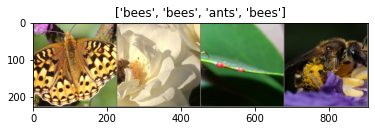

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning the convnet

In [19]:
model_ft = torchvision.models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.IMAGENET1K_V1')
num_ftrs = model_ft.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, class_num)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 1.5247 Acc: 0.6148
val Loss: 1.0048 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.5195 Acc: 0.7705
val Loss: 0.9107 Acc: 0.8105

Epoch 2/24
----------
train Loss: 0.5439 Acc: 0.7746
val Loss: 0.4713 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.4827 Acc: 0.8156
val Loss: 0.3458 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.3536 Acc: 0.8443
val Loss: 0.3849 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.4146 Acc: 0.8484
val Loss: 0.3403 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.3061 Acc: 0.9016
val Loss: 0.3512 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3708 Acc: 0.8811
val Loss: 0.3545 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.2630 Acc: 0.9139
val Loss: 0.3244 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3654 Acc: 0.8484
val Loss: 0.3352 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3012 Acc: 0.8730
val Loss: 0.3002 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2677 Acc: 0.8975
val Loss: 0.3060 Acc: 0.9085

Ep

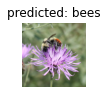

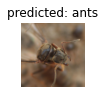

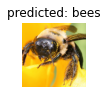

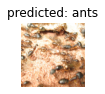

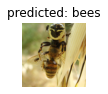

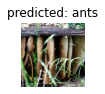

In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

visualize_model(model_ft)

### ConvNet as fixed feature extractor

In [14]:
model_conv = torchvision.models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.IMAGENET1K_V1')

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[1].in_features
model_conv.classifier = nn.Linear(num_ftrs, class_num)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 0.6345 Acc: 0.6639
val Loss: 0.4033 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.5486 Acc: 0.7254
val Loss: 0.3413 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4099 Acc: 0.8156
val Loss: 0.2757 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3938 Acc: 0.8402
val Loss: 0.2560 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.5034 Acc: 0.7828
val Loss: 0.2691 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4785 Acc: 0.7705
val Loss: 0.3174 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4465 Acc: 0.8033
val Loss: 0.2657 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3126 Acc: 0.8566
val Loss: 0.2645 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3771 Acc: 0.8238
val Loss: 0.2991 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3609 Acc: 0.8402
val Loss: 0.2802 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3648 Acc: 0.8361
val Loss: 0.2708 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2753 Acc: 0.8811
val Loss: 0.2663 Acc: 0.9412

Ep

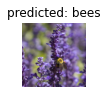

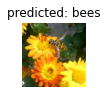

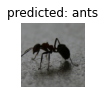

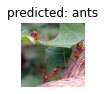

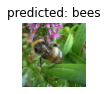

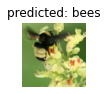

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

visualize_model(model_conv)

plt.ioff()
plt.show()